# General VQE example

Right now, we are building our library to work together with Tequila ([Github](https://github.com/aspuru-guzik-group/tequila), [paper](https://arxiv.org/pdf/2011.03057.pdf)). So let's start with importing it.

In [1]:
import tequila as tq

Lets also import numpy for easy calculations

In [2]:
import numpy as np
from LibMark2.quantmark import Qresult

## Create Molecules
The Variational Quantum Eigensolver (VQE) algorithm "simulates" molecules on a quantum level. This basically comes down to that it is able to find the "ground state energy" (the energy belonging to the lowest state it can be in) of the molecule. This is interesting because chemicals like to be in their lowest energy state.

A VQE works by approximating the eigenvalues of a matrix. In quantum chemistry, the molecule is represented by a matrix called the Hamiltonian such that the eigenvalues of the Hamiltonian correspond to the possible energy level of the molecule and the eigenvectors represent the molecular states. The lowest eigenvalue is the lowest energy state, which is the one we are trying to find.

In order to represent this molecule on a quantum computer, we need to agree on a method to turn electron states of the molecule to qubits. And ofcourse, there are multiple ways you can do this and they depend on your `basis_set` (analogous to 3D systems: what is up? Left-handed vs right-handed systems). Although there are many choices for the `basis_set`, `"sto-3g"` is the most commenly used one in VQE. The choice of `transformation` is a bit more controversial. There are multiple camps, but the 2 largest are `"jordan-wigner"` and `"bravyi-kitaev"`. Here is a [paper](https://arxiv.org/pdf/1812.02233.pdf) that compares the two with a more detailed explanation.

Below we create a hydrogen molecule and a Lithium Hydride molecule. The former consists of two H atoms, and the latter of a Li atom and a H atom. One is located in the origin (0.0, 0.0, 0.0) and the other is a distance `R` away (0.0, 0.0,`R`). This is called the `geometry`.

Tequila takes care of the inter-library communication and has a simple Molecule class that we use. Under the surface, it actually uses the molecule representation of which ever chemistry library you have installed. I used [`psi4`](https://psicode.org/), but [`pyscf`](https://pyscf.org/) and [`madness`](https://github.com/m-a-d-n-e-s-s/madness) are also popular, supported choices.

In [3]:
def create_H2(R, basis_set="sto-3g", transformation="jordan-wigner", **kwargs): 
    geometry = f'H 0.0 0.0 0.0\nH 0.0 0.0 {R}'
    return tq.chemistry.Molecule(geometry=geometry, basis_set=basis_set, transformation=transformation, **kwargs)

def create_LiH(R, basis_set="sto-3g", transformation="jordan-wigner", **kwargs):
    geometry = f'Li 0.0 0.0 0.0\nH 0.0 0.0 {R}'
    return tq.chemistry.Molecule(geometry=geometry, basis_set=basis_set, transformation=transformation, **kwargs)

Given a molecule and the way you want it represented, you can calculate/generate the matrix that describes the entire thing: the Hamiltonian.

Again, Tequila does the hard work for us

In [4]:
def create_hamiltonian(molecule):
    return molecule.make_hamiltonian()

### Baseline truth
We want to see if our VQE algorithm actually finds what it needs to find. To do this, we calculate the ground state energy by hand, which is a lot faster than simulating the molecule for small molecules like this, but the idea is to use this algorithm for molecules that are too large to simulate with a classical computer. Unfortunately, these molecules are also too large to simulate on current quantum computers. So it is basically a proof of concept.

We are using `"fci"` as a method for calculating the true energy since this is what is used in most, if not all, VQE papers. I am not sure what it means. Other options for psi4 can be found [here](https://psicode.org/psi4manual/master/api/psi4.driver.energy.html).

In [5]:
def calculate_true_ground_state_energy(molecule):
    return molecule.compute_energy("fci")

Unfortunately, there is a bug that sometimes gives a weird error from psi4 regarding that something is NULL in detci. It does this for some molecules (with different R) and changing the R slightly removes the error. However, this error is device dependent. Me and Leo get it for different R values. Workaround below. 

## Create the ansatz
The [ansatz](https://en.wikipedia.org/wiki/Ansatz) is the educated guess that we are going to adjust to find the solution. In principle, it can by literally any quantum circuit as long as it has sufficient amount of parameters to adjust and sufficient amount of entanglement (2-qubit gates) to represent what is actually going on in the molecule.

### UCCSD ansatz
The UCCSD ansatz is chemically-inspired. This means that the structure of the circuit reflects the structure of the molecule. You can find a bit more information about it [here](https://en.wikipedia.org/wiki/Coupled_cluster). This ansatz was originally used for the first VQE algorithm ([paper](https://arxiv.org/pdf/1304.3061.pdf)).

It is not important for you to know how it works, only that it exists and Tequila can make one for us.

In [6]:
def make_uccsd_ansatz(molecule, trotter_steps, n_qubits=None, **kwargs): 
    return molecule.make_uccsd_ansatz(trotter_steps, **kwargs)

Note that the n_qubits parameters is not used here. It is only there to unify the function call to the ansatz creation later with respect to the hardware efficient ansatz (which needs n_qubits, but not the molecule).

### Hardware efficient ansatz
The hardware-efficient ansatz attempts to take the device hardware into account when constructing the ansatz and not the molecular structure. In general, it consists of layers of parametrized single qubit rotations on each qubit and a large entangling operation (`uent`) on every qubit, created with 2-qubit gates that fit the device. This structure really resembles a fully connected neural network where the rotations are the weights.

From my compiling experience, I know that this is a crazy inefficient structure. Moreover, in practice `uent` is structured in a line and then run on quantum devices whose architectures don't support a line. This is where I want to make changes, but I need a baseline to compare to.

The hardware-efficient ansatz was originally proposed in [this paper](https://arxiv.org/abs/1704.05018). Originally, it took _45 days_ to run on an actual IBM quantum computer for the LiH molecule, but IBM recently managed to improve that time to _9 hours_ using more efficient code ([see announcement](https://research.ibm.com/blog/120x-quantum-speedup?lnk=ushpv18re2)).

In [7]:
def create_uent(n_qubits):
    circuit = tq.QCircuit()
    for i in range(1, n_qubits, 2):
        circuit += tq.gates.CZ(target=i, control=i-1)
    for i in range(2, n_qubits, 2):
        circuit += tq.gates.CZ(target=i, control=i-1)
    return circuit


def create_rotations(n_qubits, depth_position):
    circuit = tq.QCircuit()
    for qubit in range(n_qubits):
        circuit += tq.gates.Rz(f'{qubit}^{depth_position}_0',target=qubit)
        circuit += tq.gates.Rx(f'{qubit}^{depth_position}_1',target=qubit)
        circuit += tq.gates.Rz(f'{qubit}^{depth_position}_2',target=qubit)
    return circuit

def make_hardware_ansatz(n_qubits, d, uent = None, **kwargs):
    if not uent:
        uent = create_uent(n_qubits)
    circuit = create_rotations(n_qubits, 0)
    for depth in range(0, d):
        circuit += uent
        circuit += create_rotations(n_qubits, depth)
    return circuit

## Optimizer
The optimizer is basically a function to determine how to change the parameters in the ansatz based on its performance the full algorithm. In most VQE papers this is done either using the `"Nelder-Mead"` simplex method or the `"BFGS"` optimizer. I believe both are exact optimizers, so I am still curious to see whether it can be sped up using an approximate optimizer. 

Luckily, Tequila takes care of all this and we only need to give a string to `tq.minimize(...)` together with the problem description.

In [8]:
optimizer="Nelder-Mead" # Alternatively: "BFGS"

# Main loop

In the VQE papers, when showing the performance of the algorithm, they generally plot the obtained ground state energy against different inter-atomic distances in the molecule. We are doing the same. 

I recommend to only use the H2 when trying different things. LiH took about a day on my desktop with i7 and GTX 1070 (CUDA accelerated) with the UCCSD ansatz, 10 trotter steps and 7 orbital distances. That is not suitable for trying things out.

In [9]:
step = 0.25
molecular_distances = np.arange(.0 + step, 2.0 + step, step) # Quick one-based iterator with given step size.
print(*molecular_distances)

0.25 0.5 0.75 1.0 1.25 1.5 1.75 2.0


As said before, psi4 might give an error when calculating the ground truth. As a workaround we try again with a similar, but different value. We store the new distances for easy plotting later. The molecules with the approximate distances between the molecules are also used for the VQE for direct comparison.

In [10]:
# psi4 error workaround
def create_molecules(molecule_function, distances):
    molecules = []
    actual_distances = []
    true_energies = []
    for r in distances:
        success = False
        while not success:
            try:
                molecule = molecule_function(r)
                energy = calculate_true_ground_state_energy(molecule)
                success = True
            except:
                print("Error with distance", r)
                r -= 0.001 #Try again with a slightly smhttp://0.0.0.0:8000/api/aller distance
        molecules.append(molecule)
        actual_distances.append(r)
        true_energies.append(energy)
    return molecules, actual_distances, true_energies
            

# Create the molecules
molecules, distances, truth = create_molecules(create_H2, molecular_distances) 

Error with distance 1.75
Error with distance 2.0
Error with distance 1.999


In [11]:
# Note that you can also retroactively find the molecular distance in the geometry of the molecule object.
molecules[0].parameters.get_geometry()[-1][-1][-1]

0.25

Given all the components, we can put together the main loop.

From the molecule, we make the hamiltonian `H`. 
Then we can make the ansatz `U` which requires the `molecule` if it is chemically-inspired and the number of qubits `n_qubits` if it is hardware efficient. 
For the optimizer, we need to know the objective function `E`, which is the expection of the ansatz and hamiltonian together. A more detailed explanation with math example can be found [here](https://github.com/Le0nerdo/random/blob/main/Using_VQE_to_Approximate_the_Lowest_Eigenvalue_of_a_Hermitian_Matrix.ipynb).
The variables of the optimizer are the parameterized gates in the ansatz `U`.
Then we can find an approximate minimal solution using the given optimizer method, `optimizer`.

In [12]:
# Generic batch optimize for "any" VQE
def run_vqe(molecules, hamiltonian_function, ansatz_function, optimizer, silent=True, **ansatz_kwargs):
    results = []
    qresult = Qresult(optimizer)
    for i, molecule in enumerate(molecules):
        print(str(i+1)+"/"+str(len(molecules)), end="\t")
        print("Creating the Hamiltonian.", end="\t")
        H = hamiltonian_function(molecule)
        n_qubits = len(H.qubits)
        print("Creating ansatz.", end="\t")
        U = ansatz_function(molecule=molecule, n_qubits=n_qubits, **ansatz_kwargs)
        print("Creating objective function")
        E = tq.ExpectationValue(H=H, U=U)
        variables = {k:0.0 for k in U.extract_variables()}
        print("Optimizing.", end="\t")
        result = tq.minimize(objective=E, method=optimizer, initial_values=variables, silent=silent)
        print()
        results.append(result)
        print(result)
        qresult.add_run(result, molecule, H, U)
    print("Done")
    #qresult.push()
    return results

To run the above loop with the uccsd ansatz, we nee do pick the amout of `trotter_steps` that are needed to create the ansatz. More steps is more accurate chemical representaiton, but also a larger circuit. I just picked 10 arbitrarily

In [13]:
uccsd_ansatz_kwargs = {"trotter_steps": 3}
uccsd_results = run_vqe(molecules, create_hamiltonian, make_uccsd_ansatz, optimizer, **uccsd_ansatz_kwargs)

1/8	Creating the Hamiltonian.	Creating ansatz.	Creating objective function
Optimizing.	
2/8	Creating the Hamiltonian.	Creating ansatz.	Creating objective function
Optimizing.	
3/8	Creating the Hamiltonian.	Creating ansatz.	Creating objective function
Optimizing.	
4/8	Creating the Hamiltonian.	Creating ansatz.	Creating objective function
Optimizing.	
5/8	Creating the Hamiltonian.	Creating ansatz.	Creating objective function
Optimizing.	
6/8	Creating the Hamiltonian.	Creating ansatz.	Creating objective function
Optimizing.	
7/8	Creating the Hamiltonian.	Creating ansatz.	Creating objective function
Optimizing.	
8/8	Creating the Hamiltonian.	Creating ansatz.	Creating objective function
Optimizing.	
Done


In [14]:
#print(uccsd_results.get_types())


In [15]:
#print(uccsd_results.get_results())

Similarly, for the hardware efficient ansatz, we need to pick the number of layers. We try a few different ones.

In [16]:
"""
n_layers = range(2, 4) 
hardware_results = []
for layers in n_layers:
    print("Hardware efficient ansatz with", layers, "layers.")
    hardware_ansatz_kwargs = {"d":layers}
    result = run_vqe(molecules, create_hamiltonian, make_hardware_ansatz, optimizer, **hardware_ansatz_kwargs)
    hardware_results.append(result)
"""

'\nn_layers = range(2, 4) \nhardware_results = []\nfor layers in n_layers:\n    print("Hardware efficient ansatz with", layers, "layers.")\n    hardware_ansatz_kwargs = {"d":layers}\n    result = run_vqe(molecules, create_hamiltonian, make_hardware_ansatz, optimizer, **hardware_ansatz_kwargs)\n    hardware_results.append(result)\n'

# Plotting results

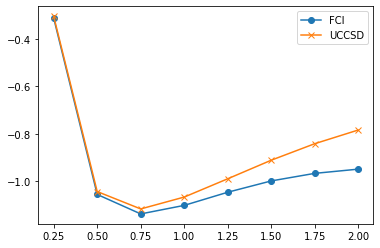

In [17]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(distances, truth, marker="o", label="FCI")
plt.plot(distances, [result.energy for result in uccsd_results], marker="x", label="UCCSD")
"""
for i, layer in enumerate(n_layers):
    plt.plot(distances, [result.energy for result in hardware_results[i]], marker="o", label="d="+str(layer))
"""
plt.legend()
plt.show()


# Python tips

In stead of looking for documentation of the exact name of a function or attribute you are looking for, you can also you `__dict__` to peak into the object.

In [18]:
uccsd_results[1].__dict__

{'energy': -1.0429962747511703,
 'history': OptimizerHistory(energies=[-1.0429962747511703, -1.0429116938644443], gradients=[], angles=[{(1, 0, 1, 0): 0.0}, {(1, 0, 1, 0): 0.00025}], energies_calls=[], gradients_calls=[], angles_calls=[]),
 'variables': (1, 0, 1, 0) : 0.0,
 'scipy_result':  final_simplex: (array([[0.     ],
        [0.00025]]), array([-1.04299627, -1.04291169]))
            fun: -1.0429962747511703
        message: 'Optimization terminated successfully.'
           nfev: 2
            nit: 1
         status: 0
        success: True
              x: array([0.])}

Use iterators and list comprehension (also works for dicts) to make simple one-line for loops. Although you can create very complicated one-liners this way, it does not help the understandability of the code.

Below a one-liner that prints the error of the UCCSD ansatz for each distance.

In [19]:
print({d:r.energy - t for d,t,r in zip(distances, truth, uccsd_results)})

{0.25: 0.007269368942942944, 0.5: 0.0121635199368475, 0.75: 0.020965618422907673, 1.0: 0.03504168094764282, 1.25: 0.056669330520575656, 1.5: 0.08727579897565052, 1.749: 0.12482700863733986, 1.9980000000000002: 0.16453556184020945}


Use push function

IndentationError: unexpected indent (<ipython-input-18-b343266d738a>, line 2)